In [1]:
from fastai import *
from fastai.text import * 

import pdb

In [2]:
#from fastai.utils import *

In [3]:
#show_install()

In [4]:
path = Path('data')

In [5]:
@dataclass
class TrackerCallback(LearnerCallback):
    "A `LearnerCallback` that keeps track of the best value in `monitor`."
    monitor:str='val_loss'
    mode:str='auto'
    
    def __post_init__(self):
        if self.mode not in ['auto', 'min', 'max']:
            warn(f'{self.__name__} mode {self.mode} is invalid, falling back to "auto" mode.')
            self.mode = 'auto'
        mode_dict = {'min': np.less, 'max':np.greater}
        mode_dict['auto'] = np.less if 'loss' in self.monitor else np.greater
        self.operator = mode_dict[self.mode]
    
    def on_train_begin(self, **kwargs:Any)->None:
        self.best = float('inf') if self.operator == np.less else -float('inf')
    
    def get_monitor_value(self):
        values = {'trn_loss':self.learn.recorder.losses[-1:][0].cpu().numpy(),
                  'val_loss':self.learn.recorder.val_losses[-1:][0]}
        for i, name in enumerate(self.learn.recorder.names[3:]):
            values[name]=learn.recorder.metrics[-1:][0][i] 
        if values.get(self.monitor) is None:
            warn(f'{self.__name__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:]))}')   
        return values.get(self.monitor)

In [6]:
@dataclass
class SaveModel(TrackerCallback):
    "A `LearnerCallback` that saves the model when monitored quantity is best."
    every:str='improvement'
    name:str='bestmodel'
    def __post_init__(self):
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        super().__post_init__()
   
    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch": learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                learn.save(f'{self.name}')
    
    def on_train_end(self, **kwargs):
        if self.every=="improvement": learn.load(f'{self.name}')

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [53]:
df = pd.read_csv(path/'test2.csv')
df.head()

,qid,question_text,Target
0,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...,0
1,000156468431f09b3cae,How much does a tutor earn in Bangalore?,0
2,000227734433360e1aae,What are the best made pocket knives under $20...,0
3,0005e06fbe3045bd2a92,Why would they add a hypothetical scenario tha...,0
4,00068a0f7f41f50fc399,What is the dresscode for Techmahindra freshers?,0


In [54]:
# Language model data
data_lm = TextLMDataBunch.from_csv(path, 'train.csv', test='test2.csv', text_cols=1, label_cols=2)

In [55]:
data_lm.save()

In [7]:
data_lm = TextLMDataBunch.load(path, bs=64)

In [8]:
data_lm.show_batch()

idx,text
0,"xxbos xxfld 1 xxmaj will xxunk the trophy with out starc or will xxunk the trophy with starc ? xxbos xxfld 1 xxmaj what type of sin is occurred if a person tells he is the messenger of xxmaj allah in xxmaj islamic perspective ? xxbos xxfld 1 xxmaj if your 12 year old self got control of your body for a day , would anyone notice a difference ?"
1,xxfld 1 xxmaj what is the xxmaj philippine xxmaj preamble of 1987 ? xxbos xxfld 1 xxmaj how do you say ' my heart is heavy ' in xxmaj hindi ? xxbos xxfld 1 xxmaj how do people bleach their hair at home itself ? xxbos xxfld 1 xxmaj how would you describe the causes of a sudden death ? xxbos xxfld 1 xxmaj are xxmaj amway products safe and
2,"etc . ? xxmaj is the number of xxmaj democrat and xxmaj republican voters an accurate representation of such ? xxbos xxfld 1 xxmaj someone starts a controversial conversation , you ask a question , they refuse to answer , they become angry ; why would they block the one asking the question ? xxbos xxfld 1 xxmaj what are the different softwares and tools that every phd scholar should"
3,"engineering after doing bachelors in engineering sciences ? xxbos xxfld 1 xxmaj will xxmaj catalonia 's independence declaration lead to xxup eu collision ? xxbos xxfld 1 xxmaj if masturbation is not wrong , then why do people feel guilty the first time they do it , regardless of their religious / family / cultural background ? xxbos xxfld 1 xxmaj which weapon caused the most casualties in ww1 ?"
4,"xxbos xxfld 1 xxmaj what is the limit of first year students to attend xxmaj hogwarts ? xxbos xxfld 1 xxmaj if we could travel towards a distant star at the speed of light , and the star exploded , would we observe the light it emits at 2x the speed ? xxbos xxfld 1 xxmaj why do we need to recycle power in case we change any parameter in"


In [9]:
data_lm.batch_size

64

In [59]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.5)

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


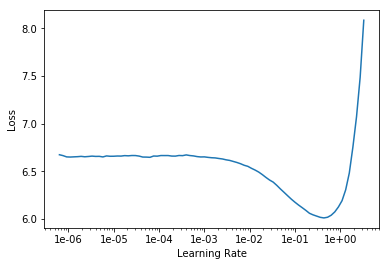

In [14]:
learn.recorder.plot()

In [15]:
lr = 1e-1 

In [16]:
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy
1,4.293741,4.093857,0.377770


In [17]:
learn.unfreeze()

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


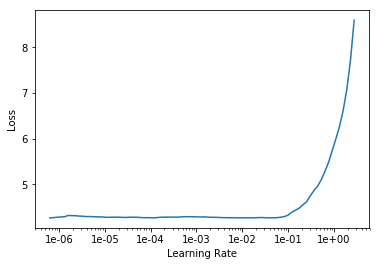

In [19]:
learn.recorder.plot()

In [20]:
lr = 1e-2

In [21]:
learn.callback_fns.append(partial(SaveModel, every='improvement', monitor='val_loss'))

In [22]:
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,accuracy
1,3.592351,3.501143,0.432068
2,3.456820,3.364794,0.438699
3,3.413259,3.325716,0.442025
4,3.365173,3.285341,0.445231
5,3.349274,3.244561,0.449299
6,3.288373,3.196077,0.453886
7,3.216974,3.143511,0.458470
8,3.146059,3.095133,0.463485
9,3.078264,3.060478,0.467168
10,3.042212,3.052990,0.468041


In [65]:
#learn = learn.load('bestmodel')

In [68]:
#learn.load_encoder('ft_enc')

In [70]:
learn.predict("Hello my", n_words=10)

'Hello my solar notification ’s diabetes sulfur earns to erp someone vintage'

In [25]:
learn.save_encoder('ft_enc')

In [89]:
df.from_csv('data/train.csv').head()

/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


,question_text,target
qid,,
00002165364db923c7e6,How did Quebec nationalists see their province...,0
000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [90]:
df.from_csv('data/test2.csv').head()

/home/dollofcuty/anaconda3/envs/fastai_updated/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


,question_text,Target
qid,,
00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...,0
000156468431f09b3cae,How much does a tutor earn in Bangalore?,0
000227734433360e1aae,What are the best made pocket knives under $20...,0
0005e06fbe3045bd2a92,Why would they add a hypothetical scenario tha...,0
00068a0f7f41f50fc399,What is the dresscode for Techmahindra freshers?,0


In [10]:
#Classifier model data
data_clas = (TextList.from_csv(path, 'train.csv', cols='question_text',vocab=data_lm.vocab)
                .random_split_by_pct(0.1) 
                .label_from_df(cols='target')
                .databunch())

In [11]:
##Classifier model data
#data_clas = (TextList.from_csv(path, 'train.csv', cols='question_text', vocab=data_lm.train_ds.vocab)
#                .random_split_by_pct(0.1) 
#                .label_from_df(cols='target')
#                .databunch())
#
#                #.add_test(TextList.from_df(test_df, path, cols='question_text'))

In [341]:
#Classifier model data
data_clas = TextClasDataBunch.from_csv(path, 'train.csv', test='test2.csv', vocab=data_lm.train_ds.vocab, 
                                       text_cols=1, label_cols=2, bs=64)

In [342]:
data_clas.save('tmp_clas')

In [327]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=64)

In [12]:
data_clas.batch_size

32

In [13]:
len(data_clas.train_ds), len(data_clas.valid_ds)#, len(data_clas.test_ds)

(1175510, 130612)

In [14]:
data_clas.show_batch()

text,target
xxbos xxmaj what is [ math ] \ frac { \ xxunk } } \ tan ( \ tan ( { \ boxed { \ xxunk } \ sum _ { \ xxunk { \ infty } \ xxunk } \ sum _ { \ xxunk { \ infty } \ underbrace { \ xxunk } } _ { \ text{gauss 's xxmaj law of xxmaj theoretical xxmaj probability .,1
"xxbos xxmaj people in xxmaj china , xxmaj quora is banned , xxmaj google is banned , xxmaj facebook is banned , insta , xxmaj twitter is banned , how do you guys live , oh wait there 's no one from xxmaj china on xxmaj quora lol , ok xxup hk guys tell us how do they live without internet ?",1
"xxbos xxmaj should the xxup u.s. get out of the xxmaj middle xxmaj east and let xxmaj iran , xxmaj israel , xxmaj saudi xxmaj arabia , and all the other religious countries slaughter each other off ? xxmaj once that melee is over , the xxup u.s. can have trade relationships with the surviving rational secular people ?",1
"xxbos xxmaj can a non citizen , xxup f1 student in the xxup us , start a consulting firm offering financial advice ? xxmaj would it need to be an established xxup llc and would i need an investor , even though the firm does not require funds to run , especially if i 'm the only employee ?",0
"xxbos xxmaj today i just suddenly forgot my xxup pin to credit card and remembered after an hour . i was paying with my card 15 minutes before that . xxup pin is something i would never forget , how is it possible ? xxmaj will this type of scenario happen ever again in my life ?",0


In [15]:
data_clas.show_batch(ds_type=DatasetType.Valid)

text,target
xxbos xxmaj what is [ math ] \ overbrace { \ sum _ { \ xxunk { \ infty } \ vec { \ frac { \ sum _ { \ xxunk { \ infty } \ xxunk { \ xxunk xxunk } \ div xxunk + { \ xxunk \ vec { \ xxunk xxrep 5 } { \ sum _ { \ xxunk { \ infty } \,1
xxbos xxmaj what are some numerical methods to solve [ math ] \ frac { \ xxunk \ phi } { \ delta x^2 } + \ frac { \ xxunk \ phi } { \ delta y^2 } + \ xxunk \ delta \ phi } { \ delta x } + \ xxunk \ delta \ phi } { \ delta y } = c [ / math,0
xxbos xxmaj do you like xxmaj super xxmaj saiyan xxmaj blue xxmaj kaio - xxmaj ken times 1 xxmaj goku ? xxmaj do you like xxmaj super xxmaj saiyan xxmaj blue xxmaj kaio - xxmaj ken times 2 xxmaj goku ? xxmaj do you like xxmaj super xxmaj saiyan xxmaj blue xxmaj kaio - xxmaj ken times 3 xxmaj goku ? xxmaj do you like xxmaj super xxmaj saiyan xxmaj,0
"xxbos xxmaj why does xxmaj excel not sort a - z ? xxmaj for example : if i create a column and add 262 , xxup xxunk , 263 , 263 xxmaj acorn , 264 , and 265 , and then i sort them , they will come out 262 , 263 , 264 , 265 , and xxup xxunk , 263 xxmaj acorn . xxmaj is there a way",0
"xxbos xxmaj let [ math]f : \ mathbb{r } \ rightarrow \ mathbb{r } [ / math ] for which is true [ math ] \ displaystyle \ xxunk } \ xxmaj bigg ( \ xxunk \ xxmaj bigg ) xxunk \ xxunk -1 [ / xxunk do i prove that [ xxunk } [ / math ] exists , such that : [ math ] \ displaystyle \ xxunk",0


In [16]:
#data_clas.show_batch(ds_type=DatasetType.Test)

In [17]:
class fbeta_binary(Callback):
    "Computes the f_beta between preds and targets for binary text classification"

    def __init__(self, beta2 = 1, eps=1e-9,sigmoid = True):      
        self.beta2=beta2**2
        self.eps = eps
        self.sigmoid = sigmoid
    
    def on_epoch_begin(self, **kwargs):
        self.TP = 0
        self.total_y_pred = 0   
        self.total_y_true = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        y_pred = last_output
        y_pred = y_pred.softmax(dim = 1)        
        y_pred = y_pred.argmax(dim=1)
        y_true = last_target.float()
        
        self.TP += ((y_pred==1) * (y_true==1)).float().sum()
        self.total_y_pred += (y_pred==1).float().sum()
        self.total_y_true += (y_true==1).float().sum()
    
    def on_epoch_end(self, **kwargs):
        prec = self.TP/(self.total_y_pred+self.eps)
        rec = self.TP/(self.total_y_true+self.eps)
        res = (prec*rec)/(prec*self.beta2+rec+self.eps)*(1+self.beta2)        
        #self.metric = res.mean()
        self.metric = res     


In [18]:
fbeta_binary = fbeta_binary()  # default is F1

In [19]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)

In [20]:
learn.load_encoder('ft_enc')
learn.metrics = [accuracy,fbeta_binary]

In [21]:
#learn.callback_fns.append(partial(SaveModel, name='best_clas_frozen', every='improvement', monitor='val_loss'))

In [22]:
learn.lr_find(num_it=200)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


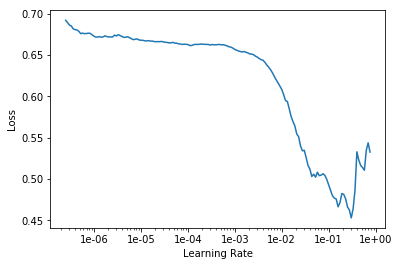

In [23]:
learn.recorder.plot()

In [24]:
lr = 2e-2

In [25]:
learn.fit_one_cycle(5, lr)#, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,fbeta_binary
1,0.205217,0.175931,0.940327,0.227552
2,0.177523,0.197503,0.938030,0.002219
3,0.145730,0.184712,0.939094,0.073600
4,0.207395,0.169266,0.941682,0.276157
5,0.186019,0.165062,0.940924,0.166919


In [26]:
learn.save('quora_clas_frozen_5e')

In [27]:
learn.freeze_to(-2)

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


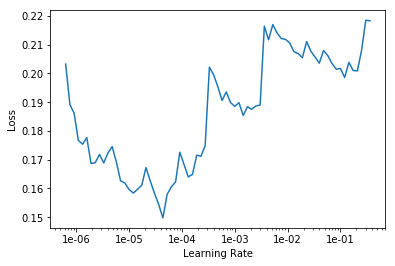

In [29]:
learn.recorder.plot()

In [30]:
lrs = slice(lr/10, lr/5)

In [31]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,accuracy,fbeta_binary
1,0.149264,0.140092,0.947616,0.436872
2,0.163839,0.138551,0.949698,0.459348
3,0.149094,0.356882,0.947042,0.454194
4,0.170853,0.145003,0.948902,0.459595
5,0.162327,0.145368,0.949775,0.461677
6,0.169566,0.133059,0.950571,0.468379
7,0.140792,0.144332,0.950870,0.459074
8,0.152346,0.127228,0.951475,0.485134
9,0.142489,0.128469,0.952960,0.525487
10,0.110853,0.126740,0.953572,0.542685


In [32]:
learn.save('quora_clas_half_unfrozen_10e')

In [33]:
learn.unfreeze()

In [34]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


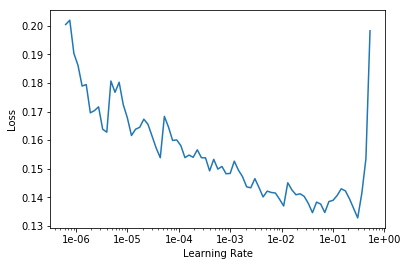

In [35]:
learn.recorder.plot()

In [36]:
lrs = slice(lr/200, lr/10)

In [37]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,accuracy,fbeta_binary
1,0.126839,0.123738,0.954147,0.551956
2,0.125463,0.124960,0.953220,0.574572
3,0.126573,0.123498,0.953304,0.561065
4,0.147688,0.124654,0.952791,0.524522
5,0.114769,0.121502,0.953075,0.547508
6,0.111972,0.119011,0.954323,0.556892
7,0.127018,0.117234,0.955065,0.597103
8,0.133173,0.116053,0.955433,0.607987
9,0.115862,0.115444,0.956443,0.605834
10,0.118571,0.114827,0.956390,0.609863


In [38]:
learn.save('quora_clas_unfrozen_10e')

In [131]:
test_df = pd.read_csv(path/'test2.csv')
test_df.head()

,qid,question_text,Target
0,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...,0
1,000156468431f09b3cae,How much does a tutor earn in Bangalore?,0
2,000227734433360e1aae,What are the best made pocket knives under $20...,0
3,0005e06fbe3045bd2a92,Why would they add a hypothetical scenario tha...,0
4,00068a0f7f41f50fc399,What is the dresscode for Techmahindra freshers?,0


In [132]:
sub_df = pd.read_csv(path/'sample_submission.csv')
sub_df.head()

,qid,prediction
0,00014894849d00ba98a9,0
1,000156468431f09b3cae,0
2,000227734433360e1aae,0
3,0005e06fbe3045bd2a92,0
4,00068a0f7f41f50fc399,0


In [133]:
len(sub_df), len(test_df)

(56370, 56370)

In [134]:
for index, row in test_df.iterrows():
    if index % 1000 == 0: print(index)
    sub_df.at[index, 'prediction'] = (learn.predict(row['question_text'])[2][0]<0.5).item()
    #sub_df['prediction'] = (learn.predict(row['question_text'])[2][0]<0.5).item()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000


In [135]:
sub_df.to_csv(path/'submission1')

In [138]:
len(sub_df[sub_df.prediction>0])

2579